In [2]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib
from lib import data_prep, feature_extraction, models
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import time
import numpy as np
from collections import Counter


font = {
    "family": "sans-serif",
    "weight": "bold",
    "size": 12
}
matplotlib.rc("font", **font)

# Loading the data

In [3]:
# Base directory
data_loc = os.path.join(os.getcwd(), "DATA")

# file name
file_names = {
    0: "machine_ON_no-ref_start-error_1.csv",  # Machine turned ON, and the parameter switch enable error
    1: "machine_ON_no-ref_start-error_2.csv",
    2: "machine_ON_no-ref_start-error_3.csv",
    3: "machine_ON_no-ref_start-error_4.csv",
    4: "machine_ON_ref_no-error_1.csv",  # Machine ON referenced and no-error idling
    5: "machine_ON_ref_no-error_2.csv",  # Machine ON referenced and no-error idling
    6: "machine_ON_ref_no-error_3.csv",
    7: "machine_ON_ref_no-error_4.csv",
    8: "machine_ON_ref_no-error_5.csv",
    9: "machine_ON_ref_no-error_6.csv",
    10: "machine_ON_ref_no-error_7.csv",
    11: "machine_ON_ref_no-error_8.csv",
    12: "machine_ON_ref_no-error_9.csv",
    13: "machine_ON_ref_no-error_10.csv",
    14: "machine_ON_ref_no-error_11.csv",
    15: "machine_ON_ref_no-error_12.csv",
    16: "machine_ON_ref_no-error_13.csv",
    17: "machine_ON_ref_overtravel-error_x_neg_1.csv",  # Machine ON referenced and Overtravel for X negative
    18: "machine_ON_ref_overtravel-error_x_pos_1.csv",  # Machine ON referenced and Overtravel for X positive
    19: "machine_ON_no-ref_overtravel-error_x_neg_1.csv",  # Machine ON not-referenced and Overtravel for X negative
    20: "machine_ON_no-ref_overtravel-error_x_pos_1.csv", # Machine ON not-referenced and Overtravel for X positive
    21: "machine_ON_ref_overtravel-error_x_neg_axes-extreme_1.csv", # Reference and overtravel in X
    22: "machine_ON_ref_overtravel-error_x_neg_axes-extreme_2.csv", # Referenced and overtravel in X
    23: "machine_ON_ref_overtravel-error_x_pos_axes-extreme_1.csv", # Referenced and overtravel in X
    24: "machine_ON_ref_overtravel-error_y_neg_axes-extreme_1.csv",  # Machine ON referenced and Overtravel for Y negative
    25: "machine_ON_ref_overtravel-error_y_neg_1.csv", # Machine and ON referenced and Overtravel in Y
    26: "machine_ON_ref_overtravel-error_y_pos_1.csv",  # Machine ON referenced and Overtravel for Y positive
    27: "machine_ON_ref_overtravel-error_y_pos_axes-extreme_1.csv",
    28: "machine_ON_ref_overtravel-error_z_neg_1.csv",  # Machine ON referenced and Overtravel for Z negative
    29: "machine_ON_ref_overtravel-error_z_neg_axes-extreme_1.csv",
    30: "machine_ON_ref_overtravel-error_z_pos_1.csv",  # Machine ON referenced and Overtravel for Z positive
    31: "machine_ON_ref_overtravel-error_z_pos_axes-extreme_1.csv",
    32: "machine_ON_no-ref_1.csv",
    33: "machine_ON_no-ref_2.csv"
}

# Segmentation

- Keeping the segmentation window consistent here at 60s

In [4]:
segment_secs = 60
wavelet_nperseg = 15

In [5]:
# Dont choose "no" and "sample_time" as they will be added later to the beginning
# Chosen - Choosing only the active power sum of all three phases
chosen_cols = ["Power1", "Power2", "Power3", "PowerReac1", "PowerReac2", "PowerReac3", "PowerApp1", "PowerApp2", "PowerApp3"]
# chosen_cols = ["PowerSum", 'PowerReacSum', 'PowerAppSum']
# chosen_cols = ["PowerSum"]
segmented_data = {}
for index, file_name in file_names.items():
    path = os.path.join(data_loc, file_name)
    temp = data_prep.segment_data(file_name=path, col_names=chosen_cols, segment_secs=segment_secs)
    # Remove the sample_time col
    temp = temp[:, 1:, :]
    segmented_data[file_name] =  temp

In [6]:
# Print to ensure that segmentation is successful
for file_name in segmented_data.keys():

    sys.stdout.write(f"For the file-{file_name} the shape-{segmented_data[file_name].shape}\n")

For the file-machine_ON_no-ref_start-error_1.csv the shape-(60, 9, 19)
For the file-machine_ON_no-ref_start-error_2.csv the shape-(60, 9, 106)
For the file-machine_ON_no-ref_start-error_3.csv the shape-(60, 9, 859)
For the file-machine_ON_no-ref_start-error_4.csv the shape-(60, 9, 5054)
For the file-machine_ON_ref_no-error_1.csv the shape-(60, 9, 243)
For the file-machine_ON_ref_no-error_2.csv the shape-(60, 9, 705)
For the file-machine_ON_ref_no-error_3.csv the shape-(60, 9, 162)
For the file-machine_ON_ref_no-error_4.csv the shape-(60, 9, 1129)
For the file-machine_ON_ref_no-error_5.csv the shape-(60, 9, 338)
For the file-machine_ON_ref_no-error_6.csv the shape-(60, 9, 1436)
For the file-machine_ON_ref_no-error_7.csv the shape-(60, 9, 4926)
For the file-machine_ON_ref_no-error_8.csv the shape-(60, 9, 2052)
For the file-machine_ON_ref_no-error_9.csv the shape-(60, 9, 3233)
For the file-machine_ON_ref_no-error_10.csv the shape-(60, 9, 1231)
For the file-machine_ON_ref_no-error_11.csv t

In [7]:
# Associations between the classes and the files in this study
class_file_association = {
    "on-ref": ["machine_ON_ref_no-error_1.csv", "machine_ON_ref_no-error_2.csv", "machine_ON_ref_no-error_3.csv", "machine_ON_ref_no-error_4.csv", "machine_ON_ref_no-error_5.csv", "machine_ON_ref_no-error_6.csv", "machine_ON_ref_no-error_7.csv", "machine_ON_ref_no-error_8.csv", "machine_ON_ref_no-error_9.csv", "machine_ON_ref_no-error_10.csv", "machine_ON_ref_no-error_11.csv", "machine_ON_ref_no-error_12.csv", "machine_ON_ref_no-error_13.csv"],

    "on-noref-error": ["machine_ON_no-ref_start-error_1.csv", "machine_ON_no-ref_start-error_2.csv", "machine_ON_no-ref_start-error_3.csv", "machine_ON_no-ref_start-error_4.csv", "machine_ON_no-ref_1.csv", "machine_ON_no-ref_2.csv"],

    "overtravel-x": ["machine_ON_ref_overtravel-error_x_neg_1.csv", "machine_ON_ref_overtravel-error_x_pos_1.csv", "machine_ON_no-ref_overtravel-error_x_neg_1.csv", "machine_ON_no-ref_overtravel-error_x_pos_1.csv", "machine_ON_ref_overtravel-error_x_neg_axes-extreme_1.csv",
    "machine_ON_ref_overtravel-error_x_neg_axes-extreme_2.csv", "machine_ON_ref_overtravel-error_x_pos_axes-extreme_1.csv"],

    "overtravel-y": ["machine_ON_ref_overtravel-error_y_neg_1.csv", "machine_ON_ref_overtravel-error_y_pos_1.csv",
                    "machine_ON_ref_overtravel-error_y_neg_axes-extreme_1.csv", "machine_ON_ref_overtravel-error_y_pos_axes-extreme_1.csv"],

    "overtravel-z": ["machine_ON_ref_overtravel-error_z_neg_1.csv", "machine_ON_ref_overtravel-error_z_pos_1.csv", "machine_ON_ref_overtravel-error_z_neg_axes-extreme_1.csv", "machine_ON_ref_overtravel-error_z_pos_axes-extreme_1.csv"],
}

In [8]:
class_segmented_data = {}
for class_instance in class_file_association.keys():
    for index, file_name in enumerate(class_file_association[class_instance]):

        if index == 0:
            class_segmented_data[class_instance] = segmented_data[file_name]
        else:
            class_segmented_data[class_instance] = np.append(class_segmented_data[class_instance], segmented_data[file_name], axis=-1)

In [9]:
# Reshape the data appropriately
for class_instance in class_segmented_data.keys():
    class_segmented_data[class_instance] = np.transpose(class_segmented_data[class_instance], (2, 1, 0))

In [10]:
# Print to ensure that the files have been loaded correctly
for class_instance in class_segmented_data.keys():

    sys.stdout.write(f"The class-{class_instance} has the shape-{class_segmented_data[class_instance].shape}\n")

The class-on-ref has the shape-(21111, 9, 60)
The class-on-noref-error has the shape-(8885, 9, 60)
The class-overtravel-x has the shape-(3469, 9, 60)
The class-overtravel-y has the shape-(2500, 9, 60)
The class-overtravel-z has the shape-(5514, 9, 60)


# Feature Extraction
- Time domain
- Frequency Domain
- Time-frequency domain

In [11]:
class_dataset_features = {}
for class_instance in class_segmented_data.keys():
    dataset_features = []
    for row in class_segmented_data[class_instance]:
        computed_features = []
        for col in row:
            freq_args = [{"axis": 0}, {"axis": 0}, {"axis": 0, "nperseg": 30}]
            freq_time_args = [{"wavelet": "db1"}, {"wavelet": "db1"}, {"wavelet": "db1"}]
            computed_features += feature_extraction.compute_all_features(col, freq_args=freq_args, freq_time_args=freq_time_args)

        # Append to a list
        dataset_features.append(computed_features)

    # Add to class instance
    class_dataset_features[class_instance] = np.array(dataset_features)

In [12]:
sys.stdout.write("After feature extraction process\n\n")
for class_instance in class_dataset_features.keys():

    sys.stdout.write(f'For the class-{class_instance} , the extracted features has the shape={class_dataset_features[class_instance].shape}\n')

After feature extraction process

For the class-on-ref , the extracted features has the shape=(21111, 153)
For the class-on-noref-error , the extracted features has the shape=(8885, 153)
For the class-overtravel-x , the extracted features has the shape=(3469, 153)
For the class-overtravel-y , the extracted features has the shape=(2500, 153)
For the class-overtravel-z , the extracted features has the shape=(5514, 153)


# Generate training data
- One shot training, no K-fold

In [13]:
class_label_associations = {
    "on-ref": 0,
    "off": 1,
    "on-noref-error": 2,
    "overtravel-x": 3,
    "overtravel-y": 4,
    "overtravel-z": 5
}
for index, class_instance in enumerate(class_dataset_features.keys()):

    temp_X = class_dataset_features[class_instance]
    temp_y = np.repeat(class_label_associations[class_instance], temp_X.shape[0])[:, np.newaxis]

    if index == 0:
        X = temp_X
        y = temp_y
    else:
        X = np.append(X, temp_X, axis=0)
        y = np.append(y, temp_y, axis=0)

# Shuffle the dataset
X, y = shuffle(X, y, random_state=42)
# To a vector format
y =  np.squeeze(y)

sys.stdout.write(f"The final combined shape-{X.shape}\n")

The final combined shape-(41479, 153)


## Splitting into training and testing data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
# Normalization if required
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Model development

- Only a single model was developed
- The model was SVM as it had the best performance in this scenario

In [16]:
# Selected best hyper-parameters
model_params = {'LogisticRegression': {'max_iter': 5000, 'multi_class': 'multinomial', 'n_jobs': 4, 'tol': 0.0001, "class_weight": "balanced"},
 'DecisionTreeClassifier': {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 100},
 'KNeighborsClassifier': {'n_neighbors': 20},
 'SVC': {'class_weight': 'balanced', 'kernel': 'linear', 'tol': 1e-07},
 'BaggingClassifier': {'n_estimators': 50},
 'RandomForestClassifier': {'class_weight': 'balanced', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 100, 'n_estimators': 200}}

In [17]:
# Create repo of models
models_repo = models.Models()
# Initialize the models
models_repo.create_models(model_params)

# Train the models
models_repo.train_models(X_train, y_train, verbose=True)

# Score the models
if len(chosen_cols) == 1:
    sys.stdout.write(f"When only considering the data column {chosen_cols[0]}\n")
for model_name in models_repo.trained_model_dict.keys():
    sys.stdout.write(f"Score for the model-{model_name} is {models_repo.trained_model_dict[model_name].score(X_test, y_test)}\n")

|| Trained - LogisticRegression ||
|| Trained - DecisionTreeClassifier ||
|| Trained - KNeighborsClassifier ||
|| Trained - SVC ||
|| Trained - BaggingClassifier ||
|| Trained - RandomForestClassifier ||
Score for the model-LogisticRegression is 0.9189971070395371
Score for the model-DecisionTreeClassifier is 0.9834860173577628
Score for the model-KNeighborsClassifier is 0.9462391513982642
Score for the model-SVC is 0.9247830279652844
Score for the model-BaggingClassifier is 0.994334619093539
Score for the model-RandomForestClassifier is 0.9932497589199615


# Feature importance

In this section all the features are considered while creating the feature importance plot

In [18]:
# Names of each of the extracted features
feature_names = [
    "rms",
    "variance",
    "peak value",
    "crest factor",
    "kurtosis fisher",
    "clearance factor",
    "impulse factor",
    "shape factor",
    "line integral",
    "peak to peak",
    "skewness",
    "peak fft",
    "energy fft",
    "PSD fft",
    "WPD-1 energy",
    "WPD-2 energy",
    "WPD-3 energy"
]

combined_features = []
for main_feature in chosen_cols:
    for feature_name in feature_names:
        combined_features.append(main_feature + " | " + feature_name)

feature_names = combined_features

In [ ]:
# To see how long it takes
feature_importance_results = {}
importances_mean = {}
importances_std = {}
start_time = time.time()
for model_name in models_repo.trained_model_dict.keys():
    clf = models_repo.trained_model_dict[model_name]
    feature_importance_results[model_name] = permutation_importance(clf, X_test, y_test, n_repeats=100, random_state=42, n_jobs=8)
    # Importances mean and std
    importances_mean[model_name] = feature_importance_results[model_name].importances_mean
    importances_std[model_name] = feature_importance_results[model_name].importances_std
elapsed_time = time.time() - start_time

print(f"Time elapsed is {elapsed_time}")

Time elapsed is 25440.72610116005


## All features

In [ ]:
# Plotting
fig = plt.figure(figsize=(15, 60))
axs = fig.subplots(6, 1)
plot_model_names = list(importances_mean.keys())
index = 0

# Subplots
for row in range(6):

    axs[row].bar(feature_names, importances_mean[plot_model_names[index]], width=0.5, yerr=importances_std[plot_model_names[index]])
    axs[row].set_xticks(range(len(feature_names)))
    axs[row].set_xticklabels(feature_names, rotation=90)

    # Set labels etc
    axs[row].set_title(f"Feature Importance using permutation on {plot_model_names[index]}")
    axs[row].set_ylabel("Decrease in mean accuracy")

    index = index + 1

# For some spacing
fig.tight_layout(pad=1.0)


Identifying the common contributors

## Selected features

Plotting only the features that were manually selected

## Top k features

Selecting and plotting the top 5 important features from all

In [23]:
top = 10

# Select the importances mean and std
selected_importances_mean = {}
selected_importances_std = {}
selected_names = {}
for model_name in importances_mean.keys():
    maxk_indices = np.squeeze(np.argpartition(importances_mean[model_name], -top)[-top:])
    # get items
    selected_importances_mean[model_name] = importances_mean[model_name][maxk_indices]
    selected_importances_std[model_name] = importances_std[model_name][maxk_indices]

    # Get top names
    selected_names[model_name] = np.array(feature_names)[maxk_indices]


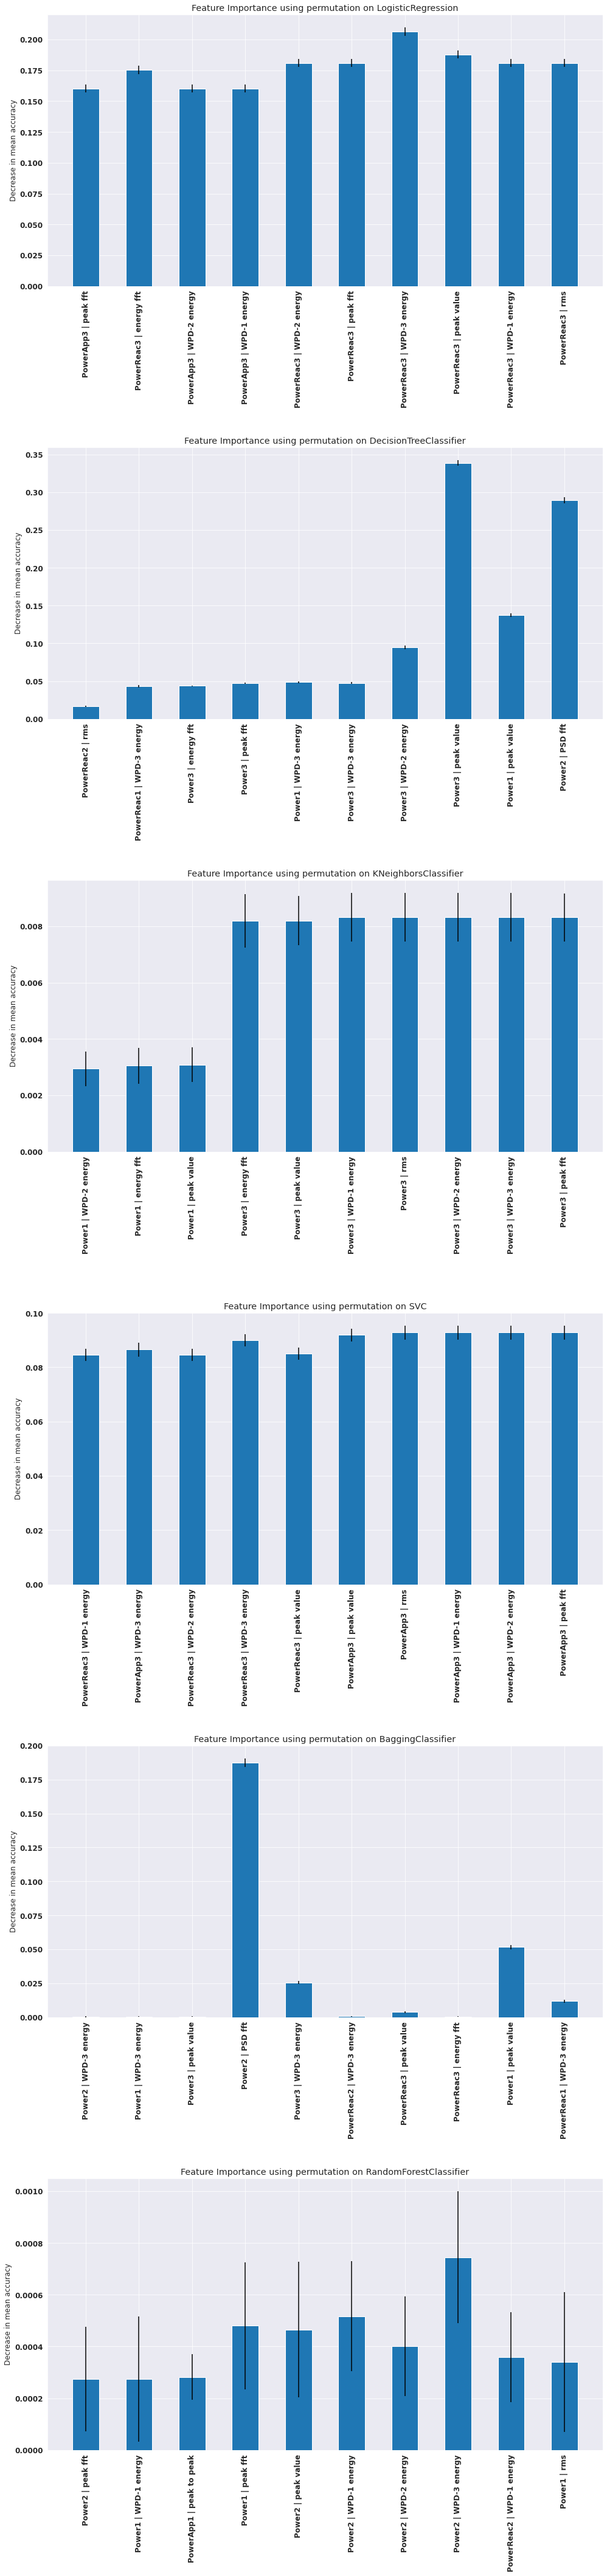

In [24]:
# Reset fonts
font = {
    "family": "sans-serif",
    "weight": "bold",
    "size": 12
}
matplotlib.rc("font", **font)

# Plotting
fig = plt.figure(figsize=(15, 60))
axs = fig.subplots(6, 1)
plot_model_names = list(importances_mean.keys())
index = 0

# Subplots
for row in range(6):

    axs[row].bar(selected_names[plot_model_names[index]], selected_importances_mean[plot_model_names[index]], width=0.5,  yerr=selected_importances_std[plot_model_names[index]])
    axs[row].set_xticks(range(len(selected_names[plot_model_names[index]])))
    axs[row].set_xticklabels(selected_names[plot_model_names[index]], rotation=90)

    # Set labels etc
    axs[row].set_title(f"Feature Importance using permutation on {plot_model_names[index]}")
    axs[row].set_ylabel("Decrease in mean accuracy")

    index = index + 1

# For some spacing
fig.tight_layout(pad=4.0)

## Identifying the top contributors

In [25]:
k = 10
model_names = list(importances_mean.keys())
energy_features = []
extracted_features = []
for model_name in importances_mean.keys():

    # Get the maximum-k for each model
    maxk_influences_indices = np.argpartition(importances_mean[model_name], -k)[-k:]
    # Get the features
    maxk_feature_names = np.array(feature_names)[maxk_influences_indices]

    # Split the maxk feature names
    for feature_name in maxk_feature_names:
        splits = feature_name.split("|")
        energy_features.append(splits[0].strip())
        extracted_features.append(splits[1].strip())

<ipython-input-31-fb2e55ab0810>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(counted_extracted_features.keys(), rotation=90)
<ipython-input-31-fb2e55ab0810>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(counted_energy_features.keys(), rotation=90)


Text(0.5, 1.0, '(b) Feature Importance on extracted features')

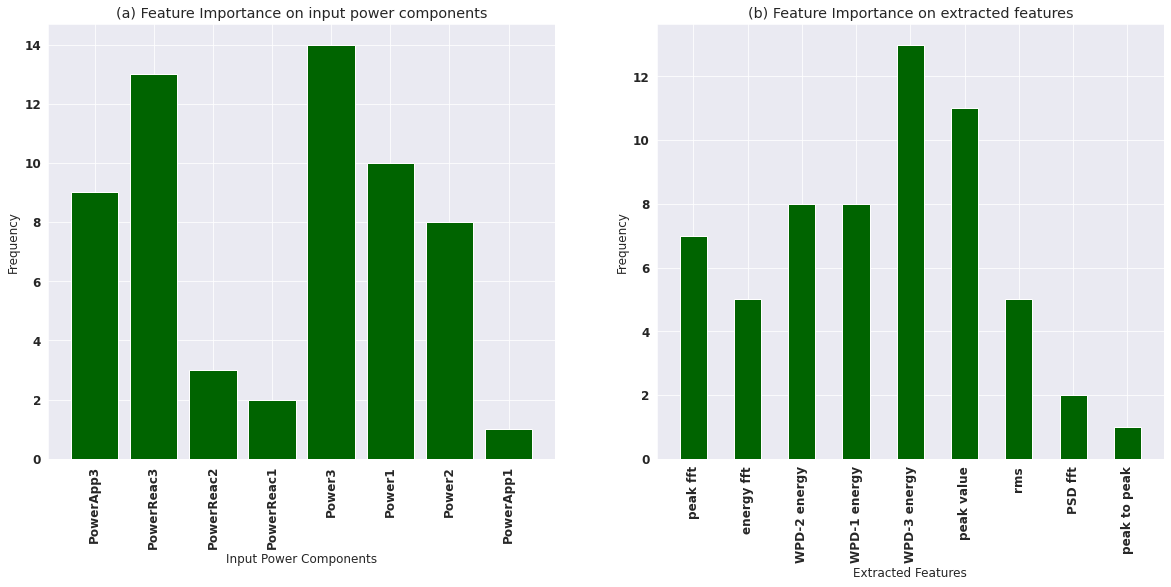

In [31]:
# Count the common contributors
counted_energy_features = Counter(energy_features)
counted_extracted_features = Counter(extracted_features)

# histogram on the counts
fig = plt.figure(figsize=(20, 8))
axs = fig.subplots(1, 2)
axs[0].bar(counted_energy_features.keys(), counted_energy_features.values(), width=0.8, color="darkgreen")
axs[1].bar(counted_extracted_features.keys(), counted_extracted_features.values(), width=0.5, color="darkgreen")
axs[1].set_xticklabels(counted_extracted_features.keys(), rotation=90)
axs[0].set_xticklabels(counted_energy_features.keys(), rotation=90)

# Labels
axs[0].set_xlabel("Input Power Components")
axs[0].set_ylabel("Frequency")
axs[0].set_title("(a) Feature Importance on input power components")

axs[1].set_xlabel("Extracted Features")
axs[1].set_ylabel("Frequency")
axs[1].set_title("(b) Feature Importance on extracted features")